In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv("CAR DETAILS FROM CAR DEKHO.csv")

In [3]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [4]:
df.isnull().sum()

name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
dtype: int64

In [5]:
from sklearn.compose import ColumnTransformer

In [6]:
numeric_features = ["year","km_driven"]
categorical_features = ["fuel","seller_type","transmission","owner"]

In [7]:
preprocessor = ColumnTransformer(
    transformers = [
    ("num",StandardScaler(),numeric_features), #standard scaling of numeric data
    ("cat",OneHotEncoder(drop="first"),categorical_features) #categorical splitting of non-numeric data
    ]
)

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X = df.drop(columns = ["selling_price"])

In [10]:
X.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,141000,Diesel,Individual,Manual,Second Owner


In [11]:
y = df["selling_price"]

In [12]:
y.head()

0     60000
1    135000
2    600000
3    250000
4    450000
Name: selling_price, dtype: int64

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = 1)

In [14]:
model_pipeline = Pipeline(steps =[
    ("preprocessing",preprocessor), #column transformer
    ("regressor",LinearRegression()) #actual model using transformed dataset
])
model_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'km_driven']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['fuel', 'seller_type',
                                                   'transmission',
                                                   'owner'])])),
                ('regressor', LinearRegression())])

In [15]:
y_pred = model_pipeline.predict(X_test)

In [16]:
from sklearn.metrics import r2_score

In [17]:
score = r2_score(y_test,y_pred)
print(score)

0.45948455237913277


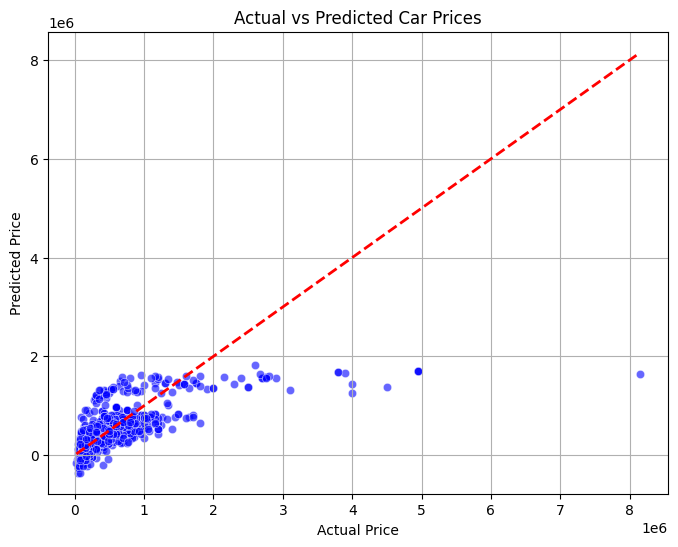

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Car Prices')
plt.grid(True)
plt.show()

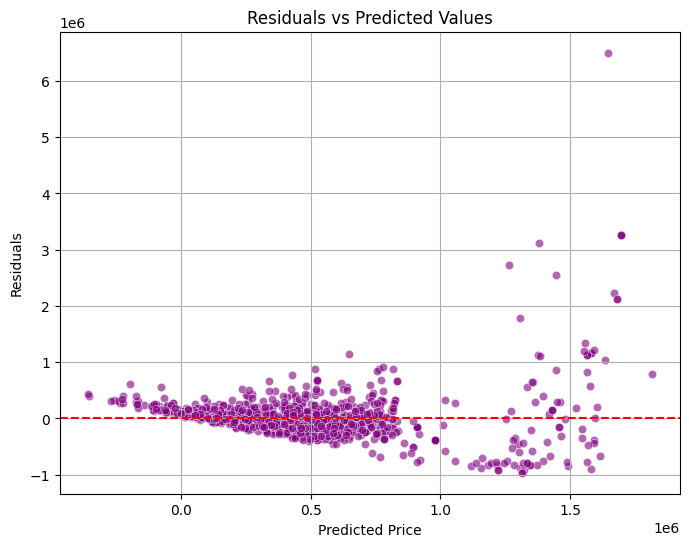

In [19]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, color='purple', alpha=0.6)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True)
plt.show()

In [20]:
df['age'] = 2023 - df['year']  # Assuming current year is 2023
df['mileage_per_year'] = df['km_driven'] / df['age']

In [21]:
df['log_selling_price'] = np.log1p(df['selling_price'])


In [22]:
X = df.drop(columns=['selling_price', 'log_selling_price', 'name'])
y = df['log_selling_price']

In [23]:
numeric_features = ['year', 'km_driven', 'age', 'mileage_per_year']
categorical_features = ['fuel', 'seller_type', 'transmission', 'owner']

In [30]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso


In [31]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Feature selection
selector = SelectKBest(score_func=f_regression, k='all')

In [32]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train and evaluate models
results = {}

In [33]:
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('selector', selector),
        ('regressor', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Convert back from log scale
    y_test_orig = np.expm1(y_test)
    y_pred_orig = np.expm1(y_pred)
    
    r2 = r2_score(y_test_orig, y_pred_orig)
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    results[name] = {'R2': r2, 'RMSE': rmse}
    print(f"{name}: R2 = {r2:.4f}, RMSE = {rmse:.2f}")

Linear Regression: R2 = 0.4645, RMSE = 402364.71
Ridge Regression: R2 = 0.4642, RMSE = 402488.54
Lasso Regression: R2 = -0.0612, RMSE = 566426.74
Random Forest: R2 = 0.5366, RMSE = 374298.47
Gradient Boosting: R2 = 0.5125, RMSE = 383887.59
XGBoost: R2 = 0.5220, RMSE = 380128.58



Best model: Random Forest with R2 = 0.5366


C:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best parameters: {'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Best R2 score: nan

Final Model Performance:
Training R2: 0.9136, Test R2: 0.5366
Training RMSE: 172726.94, Test RMSE: 374298.47

Final Model Performance:
Training R2: 0.9136, Test R2: 0.5366
Training RMSE: 172726.94, Test RMSE: 374298.47


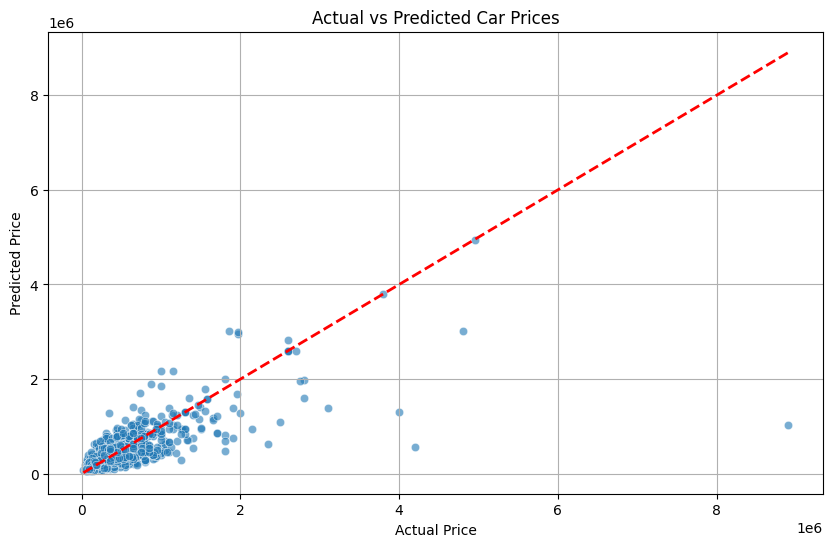

In [36]:
best_model_name = max(results, key=lambda x: results[x]['R2'])
print(f"\nBest model: {best_model_name} with R2 = {results[best_model_name]['R2']:.4f}")

# Hyperparameter tuning for the best model
if best_model_name == 'Random Forest':
    param_grid = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.05, 0.1, 0.2],
        'regressor__max_depth': [3, 5]
    }
elif best_model_name == 'XGBoost':
    param_grid = {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.05, 0.1],
        'regressor__max_depth': [3, 5, 7]
    }
else:
    param_grid = {}

if param_grid:
    grid_search = GridSearchCV(
        Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('selector', selector),
            ('regressor', models[best_model_name])
        ]),
        param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best R2 score: {grid_search.best_score_:.4f}")
    
    best_pipeline = grid_search.best_estimator_
else:
    best_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('selector', selector),
        ('regressor', models[best_model_name])
    ])
    best_pipeline.fit(X_train, y_train)

# Final evaluation
y_pred_train = np.expm1(best_pipeline.predict(X_train))
y_pred_test = np.expm1(best_pipeline.predict(X_test))

train_r2 = r2_score(np.expm1(y_train), y_pred_train)
test_r2 = r2_score(np.expm1(y_test), y_pred_test)

train_rmse = np.sqrt(mean_squared_error(np.expm1(y_train), y_pred_train))
test_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), y_pred_test))

print(f"\nFinal Model Performance:")
print(f"Training R2: {train_r2:.4f}, Test R2: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
best_pipeline.fit(X_train, y_train)

# Final evaluation
y_pred_train = np.expm1(best_pipeline.predict(X_train))
y_pred_test = np.expm1(best_pipeline.predict(X_test))

train_r2 = r2_score(np.expm1(y_train), y_pred_train)
test_r2 = r2_score(np.expm1(y_test), y_pred_test)

train_rmse = np.sqrt(mean_squared_error(np.expm1(y_train), y_pred_train))
test_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), y_pred_test))

print(f"\nFinal Model Performance:")
print(f"Training R2: {train_r2:.4f}, Test R2: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")

# Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.expm1(y_test), y=y_pred_test, alpha=0.6)
plt.plot([np.expm1(y_test).min(), np.expm1(y_test).max()], 
         [np.expm1(y_test).min(), np.expm1(y_test).max()], '--r', linewidth=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Car Prices')
plt.grid(True)
plt.show()

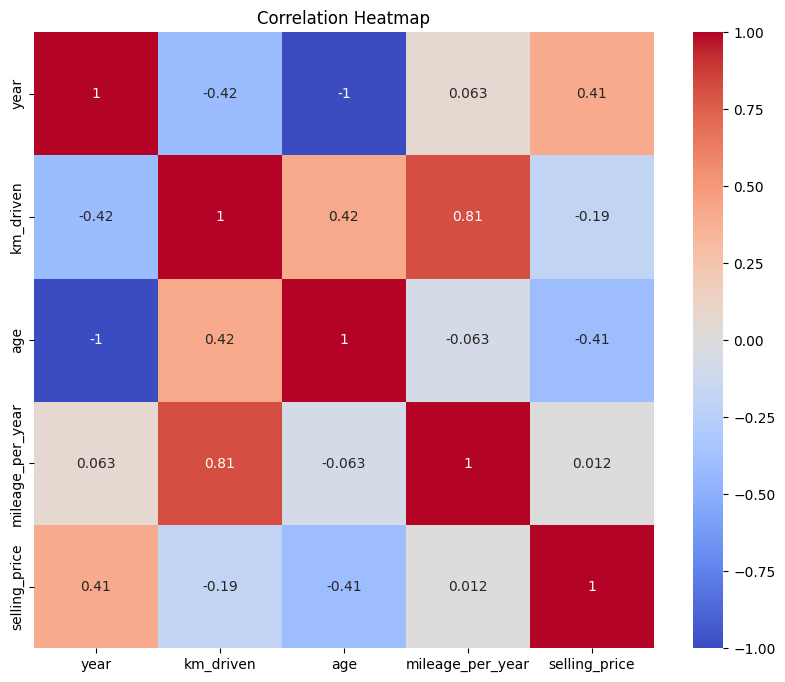

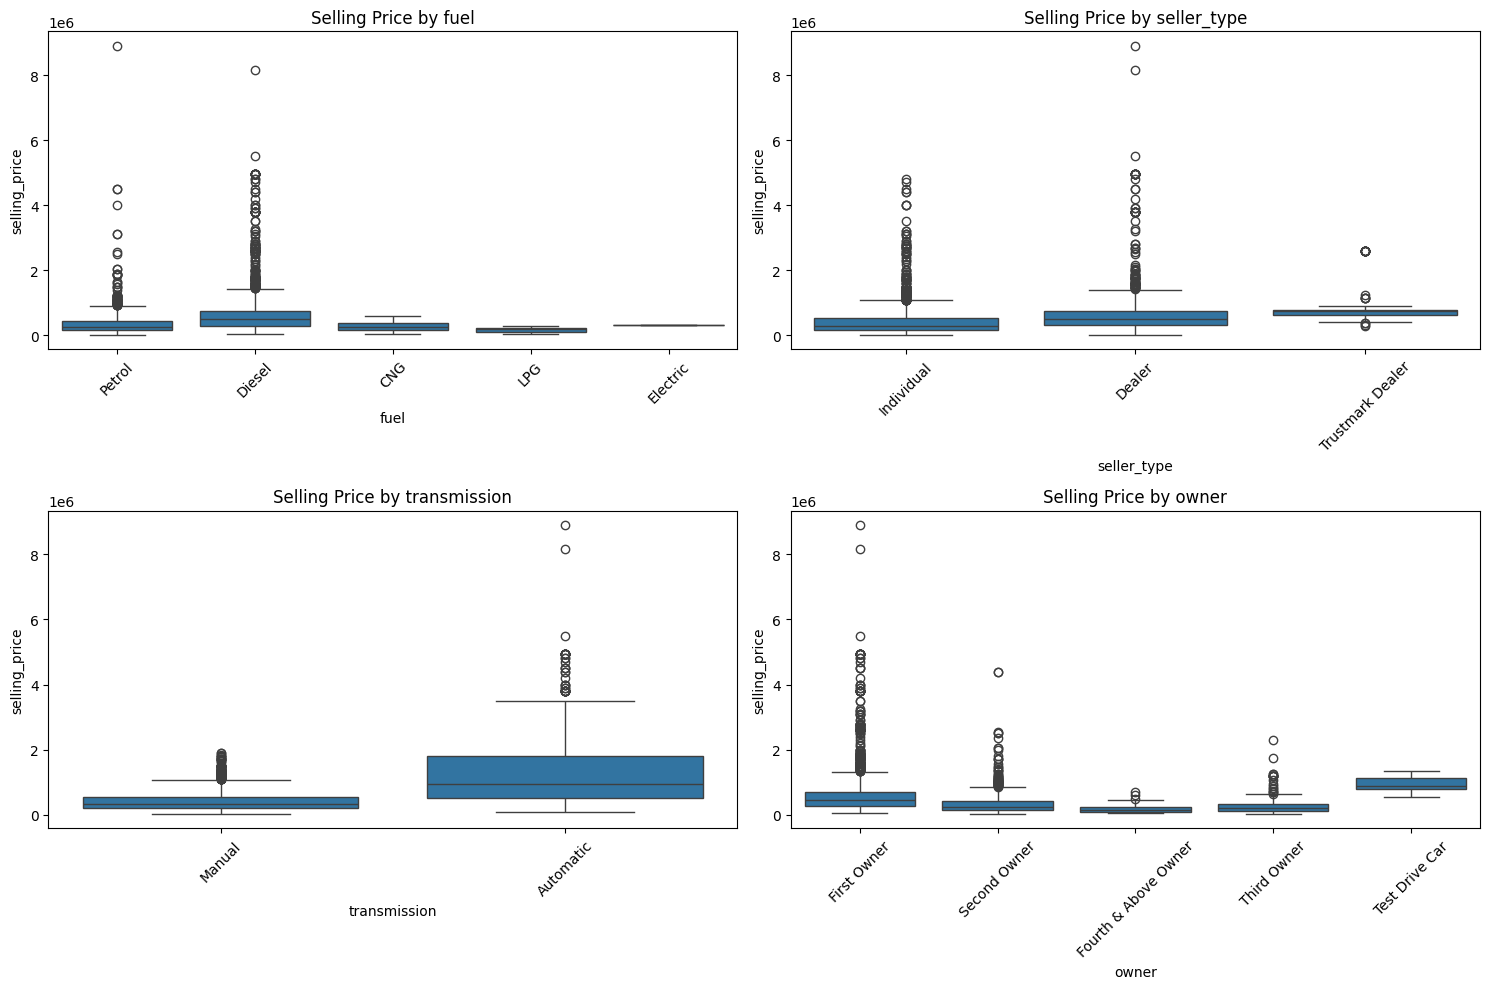

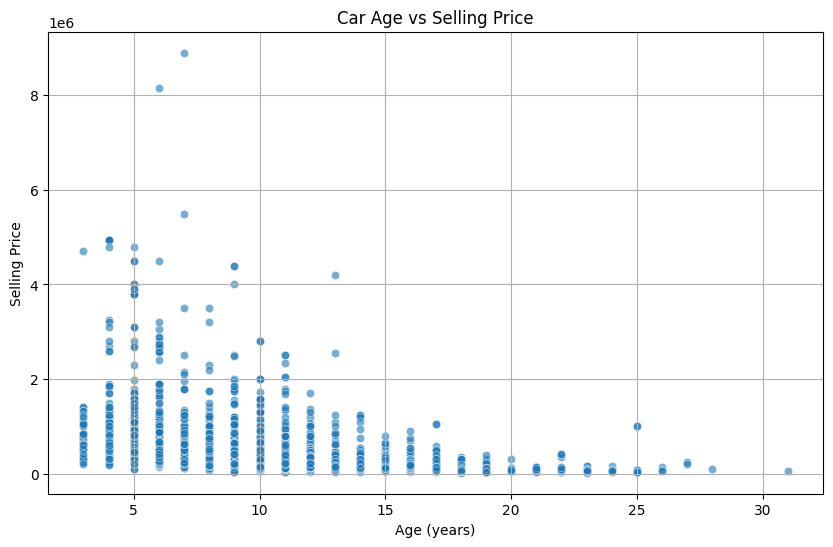

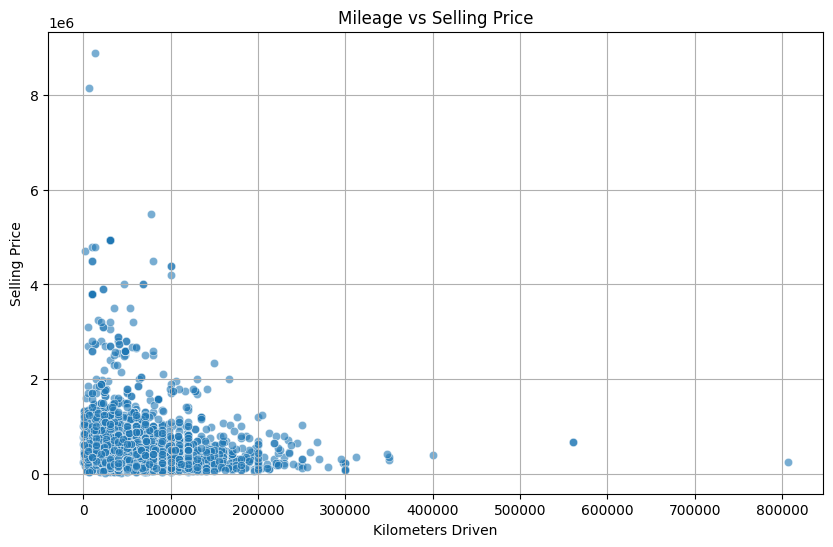

In [37]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
numeric_df = df[numeric_features + ['selling_price']]
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

# Categorical Features Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for i, feature in enumerate(categorical_features):
    row, col = i // 2, i % 2
    sns.boxplot(x=feature, y='selling_price', data=df, ax=axes[row, col])
    axes[row, col].set_title(f'Selling Price by {feature}')
    axes[row, col].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Age vs Selling Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='selling_price', data=df, alpha=0.6)
plt.title('Car Age vs Selling Price')
plt.xlabel('Age (years)')
plt.ylabel('Selling Price')
plt.grid(True)
plt.show()

# Mileage vs Selling Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='km_driven', y='selling_price', data=df, alpha=0.6)
plt.title('Mileage vs Selling Price')
plt.xlabel('Kilometers Driven')
plt.ylabel('Selling Price')
plt.grid(True)
plt.show()